The following code helps you visualize the submarine data and contains the crucial information about the data such as size of measurement domain, number of grid points and frequency modes etc. 

Our first task is to import the data into python (similarly MATLAB). Three files are available, "subdata.npy" is a numpy binary file most conveninet for Python users. "subtata.mat" is best if you plan to use MATLAB and "subdata.csv" is the same data in text format if you are having trouble with the other formats. In MATLAB you can simply use the load command. In Python, and in particular if you are using something like Colab you need some utilities to load the data. Here's a small snippet for loading data from your Google drive.   

In [192]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go


data_path = './subdata.npy'

d = np.load(data_path) # huge matrix of size 262144 x 49 (columns contain flattened 3d matrix of size 64x64x64)
data = d.reshape((64, 64, 64, 49))

# Collaborated with:

Eric Ye and Chenab

### Turns out my original intuition for going about this HW was wrong, so restarting

In [193]:
"""
Shifts the zero-frequency components to the center.
Computes the average frequency spectrum over time.
"""

N = 64

new_data_original = np.fft.fftn(data, axes=(0, 1, 2))
new_data_original = np.fft.fftshift(new_data_original, axes=(0, 1, 2))
new_data_mean = np.mean(new_data_original, axis=3)
new_data_abs = np.abs(new_data_mean)

max_val = np.unravel_index(new_data_abs.argmax(), new_data_abs.shape)
dominant = tuple(x - N//2 for x in max_val)
print("Frequencies:", dominant)


Frequencies: (7, 17, -22)


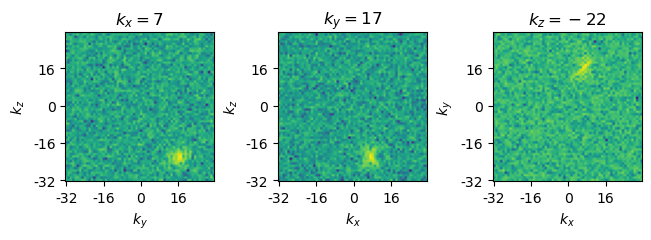

In [194]:


plt.style.use("default")

fig, axes = plt.subplots(1, 3, layout="constrained")

# Axis labels and titles for each subplot
labels = [
    ('$k_y$', '$k_z$', 0), 
    ('$k_x$', '$k_z$', 1), 
    ('$k_x$', '$k_y$', 2)
]
titles = ['$k_x = {}$', '$k_y = {}$', '$k_z = {}$']

for ax, (xlabel, ylabel, idx), title in zip(axes, labels, titles):
    im = ax.imshow(
        np.log(new_data_abs.take(max_val[idx], axis=idx).T),
        origin='lower'
    )
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(0, N, N//4))
    ax.set_xticklabels(np.arange(-N//2, N//2, N//4))
    ax.set_yticks(np.arange(0, N, N//4))
    ax.set_yticklabels(np.arange(-N//2, N//2, N//4))
    ax.set_title(title.format(dominant[idx]))


## Task 2

([<matplotlib.axis.YTick at 0x1668ff710>,
 [Text(0, 0, '-32'), Text(0, 16, '-16'), Text(0, 32, '0'), Text(0, 48, '16')])

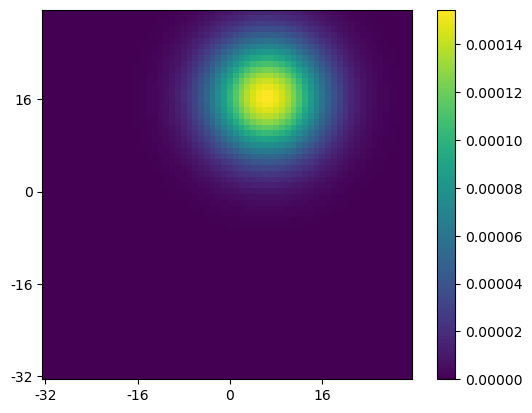

In [195]:
tau = 0.01
grid = np.linspace(-N/2, N/2, N)

kx_grid, ky_grid, kz_grid = np.meshgrid(grid, grid, grid, indexing='ij')

added_filter = np.exp(
    -tau * (
        (kx_grid - dominant[0])**2
      + (ky_grid - dominant[1])**2
      + (kz_grid - dominant[2])**2
    )
)
finalfig, ax = plt.subplots()
plt.imshow(added_filter[:, :, 39].T, origin='lower')
plt.colorbar()
plt.xticks(np.arange(0, N, 16), np.arange(-N//2, N//2, 16))
plt.yticks(np.arange(0, N, 16), np.arange(-N//2, N//2, 16))

In [196]:
new_filtered_final_data = np.fft.ifftn(
    np.fft.ifftshift(
        new_data_original * np.expand_dims(added_filter, -1), 
        axes=(0, 1, 2)
    ),
    axes=(0, 1, 2)
).real

np.save('filtered_data.npy', new_filtered_final_data)


t_step = new_filtered_final_data.shape[-1]
L = 10
grid = np.einsum('i,j,k->ijk', np.arange(N), np.arange(N), np.arange(N))
prediction = np.empty((49, 3))
x, y, z = [], [], []

# Looping to get the prediction using the maximum value of the filtered data

for i in range(t_step):
    max_idx = np.unravel_index(
        np.argmax(new_filtered_final_data[..., i]), 
        new_filtered_final_data[..., i].shape
    )
    final_idx = [(max_idx[j] - N//2) * (2*L / N) for j in range(3)]
    prediction[i] = final_idx
    x.append(final_idx[0])
    y.append(final_idx[1])
    z.append(final_idx[2])




### Time to 3D model the path!

In [197]:
fig = go.Figure(data=[go.Scatter3d(
    x=x, 
    y=y, 
    z=z,
    mode='markers+lines',
    marker=dict(
        size=5, 
        color= np.arange(0, 24.5, 0.5),
        colorscale='Viridis',
        colorbar=dict(title='Time'),
        opacity=0.8
    ),
    line=dict(color='blue', width=2)
)])


fig.update_layout(
    scene=dict(
        xaxis_title='X Coordinate',
        yaxis_title='Y Coordinate',
        zaxis_title='Z Coordinate'
    ),
    title='Trajectory of the Submarine Over Time'
)
fig.show()

# Task 3

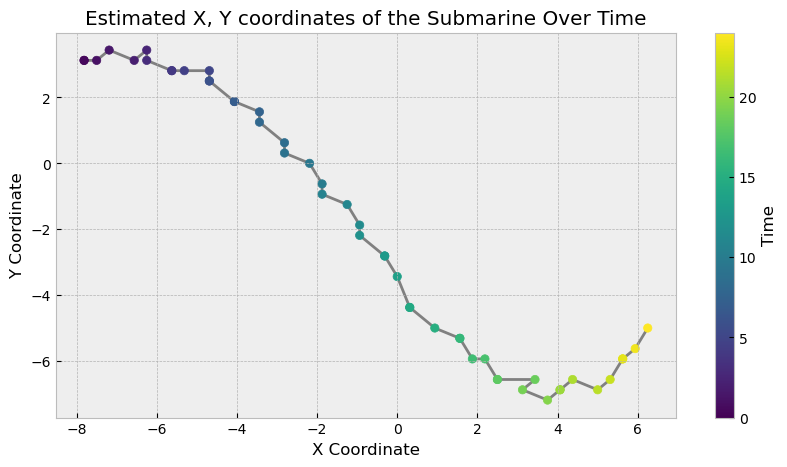

In [198]:
plt.style.use("bmh")

x = []
y = []

for i in range(t_step):
    x.append(prediction[i, 0])
    y.append(prediction[i, 1])

figure = plt.figure(figsize=(10, 5))
ax = figure.add_subplot(111)

ax.plot(x, y, marker='', linestyle='-', color='grey', zorder=-1, linewidth=2)
cbar = plt.colorbar(ax.scatter(x, y, marker='o', c=np.arange(0,24.5,0.5), cmap="viridis"))

cbar.set_label('Time')

plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Estimated X, Y coordinates of the Submarine Over Time')

plt.show()

figure.savefig('trajectory.png')